# Mushroom classification

## Importing libraries and downloading dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import zipfile
import os
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip -O "UTF-8" '/content/drive/MyDrive/Mushrooms.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Mushrooms.zip
   creating: /content/dataset/Mushrooms/
   creating: /content/dataset/Mushrooms/Agaricus/
  inflating: /content/dataset/Mushrooms/Agaricus/000_ePQknW8cTp8.jpg  
  inflating: /content/dataset/Mushrooms/Agaricus/001_2jP9N_ipAo8.jpg  
  inflating: /content/dataset/Mushrooms/Agaricus/002_hNh3aQSH-ZM.jpg  
  inflating: /content/dataset/Mushrooms/Agaricus/003_4AurAO4Jil8.jpg  
  inflating: /content/dataset/Mushrooms/Agaricus/004_Syi3NxxviC0.jpg  
  inflating: /content/dataset/Mushrooms/Agaricus/005_sUqyy4Yb9VY.jpg  
  inflating: /content/dataset/Mushrooms/Agaricus/006_1_E6AXBJqn4.jpg  
  inflating: /content/dataset/Mushrooms/Agaricus/009_mrv34Sn4WiQ.jpg  
  inflating: /content/dataset/Mushrooms/Agaricus/010_Rk1D3EG856g.jpg  
  inflating: /content/dataset/Mushrooms/Agaricus/011_WtefvQHAs0w.jpg  
  inflating: /content/dataset/Mushrooms/Agaricus/012_i_TOGa08rRE.jpg  
  inflating: /content/dataset/Mushrooms/Agaricus/013_bhSPsvLNpKk.jpg  
  inflatin

In [7]:
data_dir = pathlib.Path('/content/dataset/Mushrooms').with_suffix('')

## Checking each photo for corruption and deleting them

In [8]:
from struct import unpack
from tqdm import tqdm
import os
import os.path as osp

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}
    
class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        

def check(root_img):
  bads = []

  for file_name in os.listdir(root_img):
    img_path = osp.join(root_img,file_name)

    try:
      image = JPEG(img_path) 
      image.decode()   
      
    except:
      print(f'{img_path} is corrupted')
      os.remove(img_path)
      print(f'{img_path} is removed')
    

In [9]:
roots = ['/content/dataset/Mushrooms/Agaricus',
         '/content/dataset/Mushrooms/Amanita',
         '/content/dataset/Mushrooms/Boletus',
         '/content/dataset/Mushrooms/Cortinarius',
         '/content/dataset/Mushrooms/Entoloma',
         '/content/dataset/Mushrooms/Hygrocybe',
         '/content/dataset/Mushrooms/Lactarius',
         '/content/dataset/Mushrooms/Russula',
         '/content/dataset/Mushrooms/Suillus']

for root in roots:
  print(f'checking {root}...')
  check(root)

checking /content/dataset/Mushrooms/Agaricus...
checking /content/dataset/Mushrooms/Amanita...
checking /content/dataset/Mushrooms/Boletus...
checking /content/dataset/Mushrooms/Cortinarius...
checking /content/dataset/Mushrooms/Entoloma...
checking /content/dataset/Mushrooms/Hygrocybe...
checking /content/dataset/Mushrooms/Lactarius...
checking /content/dataset/Mushrooms/Russula...
/content/dataset/Mushrooms/Russula/139_H3FH6JjjTzg.jpg is corrupted
/content/dataset/Mushrooms/Russula/139_H3FH6JjjTzg.jpg is removed
/content/dataset/Mushrooms/Russula/092_43B354vYxm8.jpg is corrupted
/content/dataset/Mushrooms/Russula/092_43B354vYxm8.jpg is removed
/content/dataset/Mushrooms/Russula/138_QBvBBlSQ-Zs.jpg is corrupted
/content/dataset/Mushrooms/Russula/138_QBvBBlSQ-Zs.jpg is removed
checking /content/dataset/Mushrooms/Suillus...


## Creating dataset from folder

In [16]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 3574 files belonging to 9 classes.
Using 2145 files for training.
Found 3574 files belonging to 9 classes.
Using 1429 files for validation.


\

In [17]:
class_names = train_ds.class_names
print(class_names)

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


## Normalizing datasets

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating and compiling a model

In [20]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(180, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(60, 9, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(60, 9, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(180, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [21]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Training model

In [32]:
history = model.fit(  
      train_ds,
      epochs=5,  
      validation_data=val_ds)

Epoch 1/5
126/126 [==============================] - 22s 178ms/step - loss: 0.4573 - accuracy: 0.8532 - val_loss: 5.4015 - val_accuracy: 0.2768
Epoch 2/5
126/126 [==============================] - 18s 145ms/step - loss: 0.3948 - accuracy: 0.8734 - val_loss: 5.2609 - val_accuracy: 0.2630
Epoch 3/5
126/126 [==============================] - 18s 145ms/step - loss: 0.2676 - accuracy: 0.9161 - val_loss: 5.7556 - val_accuracy: 0.2586
Epoch 4/5
 28/126 [=====>........................] - ETA: 12s - loss: 0.1641 - accuracy: 0.9442

KeyboardInterrupt: ignored

## Model #2 with data augmentation

In [35]:
num_classes = len(class_names)

model1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(180, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(360, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(360, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(180, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
model1.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [40]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='sparse',
    subset='training',
)

# create validation set
validation_generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

Found 5372 images belonging to 9 classes.
Found 1339 images belonging to 9 classes.


In [41]:
history = model1.fit_generator(
      train_generator,
      epochs=30,
      validation_data=validation_generator)

<ipython-input-41-3dd84752f1be>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(


Epoch 1/30
168/168 [==============================] - 92s 546ms/step - loss: 1.7508 - accuracy: 0.3595
Epoch 2/30
168/168 [==============================] - 95s 562ms/step - loss: 1.7042 - accuracy: 0.3816
Epoch 3/30
168/168 [==============================] - 93s 553ms/step - loss: 1.6589 - accuracy: 0.4041
Epoch 4/30
168/168 [==============================] - 93s 554ms/step - loss: 1.6053 - accuracy: 0.4285
Epoch 5/30
168/168 [==============================] - 93s 555ms/step - loss: 1.5773 - accuracy: 0.4334
Epoch 6/30
168/168 [==============================] - 93s 553ms/step - loss: 1.5332 - accuracy: 0.4531
Epoch 7/30
168/168 [==============================] - 93s 549ms/step - loss: 1.5027 - accuracy: 0.4563
Epoch 8/30
168/168 [==============================] - 93s 549ms/step - loss: 1.4945 - accuracy: 0.4685
Epoch 9/30
168/168 [==============================] - 94s 558ms/step - loss: 1.4535 - accuracy: 0.4803
Epoch 10/30
168/168 [==============================] - 94s 557ms/step - l

In [47]:
history2 = model1.fit_generator(
      train_generator,
      epochs=30,
      validation_data=validation_generator)

<ipython-input-47-707cf4c38104>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model1.fit_generator(


Epoch 1/30
168/168 [==============================] - 122s 725ms/step - loss: 1.0558 - accuracy: 0.6279 - val_loss: 1.8141 - val_accuracy: 0.4093
Epoch 2/30
168/168 [==============================] - 120s 712ms/step - loss: 1.0706 - accuracy: 0.6165 - val_loss: 1.7572 - val_accuracy: 0.4347
Epoch 3/30
168/168 [==============================] - 116s 692ms/step - loss: 1.0263 - accuracy: 0.6296 - val_loss: 1.8325 - val_accuracy: 0.4220
Epoch 4/30
168/168 [==============================] - 119s 707ms/step - loss: 1.0190 - accuracy: 0.6370 - val_loss: 1.7782 - val_accuracy: 0.4167
Epoch 5/30
168/168 [==============================] - 115s 687ms/step - loss: 0.9683 - accuracy: 0.6577 - val_loss: 1.8569 - val_accuracy: 0.4541
Epoch 6/30
168/168 [==============================] - 115s 685ms/step - loss: 0.9797 - accuracy: 0.6541 - val_loss: 1.8605 - val_accuracy: 0.4361
Epoch 7/30
168/168 [==============================] - 114s 681ms/step - loss: 1.0015 - accuracy: 0.6489 - val_loss: 1.7566 -

## Using model

In [48]:
import matplotlib.image as mpimg

def decode_img(img):
  img = tf.io.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [img_height, img_width])

def predict(im_dir):
  image = tf.io.read_file(im_dir)
  plt.imshow(mpimg.imread(im_dir))

  image = decode_img(image)
  image = image/255
  image = tf.reshape(image, [-1, 180, 180, 3])
  pred = model1.predict(image)

  print(class_names[np.argmax(pred)])

1/1 [==============================] - 0s 35ms/step
Entoloma


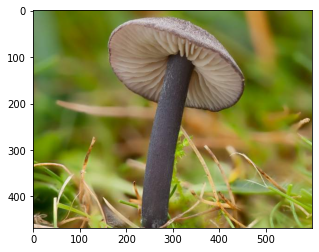

In [56]:
predict("/content/изображение_2023-02-18_193642021.png")

## Saving model

In [59]:
tf.keras.models.save_model(model1, 'model.h5')